In [1]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
print(ad.__version__)

0.7.8


# 2. Load SMART-seq data

In [3]:
data_path =r'L:\Shiwei\DNA_MERFISH_analysis\hMTG_RNAseq'

In [4]:
# load from here for saved h5ad
adata =sc.read(os.path.join(data_path, 'hMTG_smart_sn_labeled.h5ad'))

In [6]:
np.unique(adata.obs['subclass_reduced_label'])

array(['Astro', 'Exc_Cux2', 'Exc_Other', 'Lamp5', 'Micro', 'OPC', 'Oligo',
       'Pax6-Lamp5', 'Pvalb', 'Sst', 'Vip'], dtype=object)

## 2.1 Use trained network to see the cell correspondance

In [54]:
# get all genes instead of the filtered high expressing genes
adata=adata.raw.to_adata()

In [55]:
adata

AnnData object with n_obs × n_vars = 16056 × 47601
    obs: 'exp_component_name', 'specimen_type', 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_order', 'full_genotype_label', 'donor_sex_color', 'donor_sex_order', 'donor_sex_label', 'region_color', 'region_order', 'region_label', 'cortical_layer_color', 'cortical_layer_order', 'cortical_layer_label', 'cell_type_accession_color', 'cell_type_accession_order', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_order', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_order', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_order', 'cell_type_designation_label', 'external_donor_name_color', 'external_donor_name_order', 'external_donor_name_label', 'outlier_call', 'outlier_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'p

In [120]:
adata_ref = pd.DataFrame(adata.X, index=adata.obs_names, columns =adata.var_names)

adata_ref

3.8-1.2   3.8-1.3   3.8-1.4   3.8-1.5   5-HT3C2  \
sample_name                                                             
F2S4_160113_027_A01 -0.000342 -0.007234 -0.000821 -0.002555 -0.066889   
F2S4_160113_027_B01 -0.000859 -0.004757 -0.001680 -0.001242 -0.043251   
F2S4_160113_027_C01 -0.000801 -0.005033 -0.001584 -0.001389 -0.045886   
F2S4_160113_027_D01 -0.000634 -0.005837 -0.001305 -0.001815 -0.053555   
F2S4_160113_027_E01 -0.000866 -0.004723 -0.001692 -0.001224 -0.042924   
...                       ...       ...       ...       ...       ...   
F1S4_171206_398_B01 -0.000496 -0.006495 -0.001077 -0.002163 -0.059834   
F1S4_171206_398_C01 -0.000375 -0.007077 -0.000876 -0.002472  1.019930   
F1S4_171206_398_D01 -0.000234 -0.007754 -0.000641 -0.002831 -0.071851   
F1S4_171206_398_F01 -0.000493 -0.006510 -0.001072 -0.002171 -0.059977   
F1S4_171206_398_G01 -0.000276 -0.007553 -0.000710 -0.002724 -0.069934   

                         A1BG  A1BG-AS1      A1CF       A2M   A2M-AS1  ...  \
sample_name                                                            ...   
F2S4_160113_027_A01 -0.691814 -0.059753 -0.268117  2.277280 -0.075866  ...   
F2S4_160113_027_B01  4.118211 -0.102859 -0.244452 -2.177171 -0.111812  ...   
F2S4_160113_027_C01 -0.818401 -0.098053 -0.247090 -2.175944 -0.107804  ...   
F2S4_160113_027_D01  4.677535 -0.084068 -0.254768 -2.172374 -0.096142  ...   
F2S4_160113_027_E01 -0.055066 -0.103454 -0.244125 -1.396138 -0.112308  ...   
...                       ...       ...       ...       ...       ...  ...   
F1S4_171206_398_B01  2.597597 -0.072618 -0.261054  2.954605 -0.086594  ...   
F1S4_171206_398_C01 -0.700883 -0.062497 -0.266610 -0.573408 -0.078154  ...   
F1S4_171206_398_D01 -0.661907 -0.050704 -0.273084  2.133381 -0.068320  ...   
F1S4_171206_398_F01 -0.733473 -0.072357 -0.261197 -1.178684 -0.086376  ...   
F1S4_171206_398_G01 -0.673462 -0.054200 -0.271165 -2.164749 -0.071235  ...   

                         ZXDA      ZXDB      ZXDC    ZYG11A    ZYG11B  \
sample_name                                                             
F2S4_160113_027_A01 -0.134135 -0.165104  3.796979 -0.456271 -3.380351   
F2S4_160113_027_B01 -0.179551 -0.292904  4.211511 -0.342676  1.379932   
F2S4_160113_027_C01 -0.174488 -0.278656 -2.736109  0.455277  1.706957   
F2S4_160113_027_D01 -0.159754 -0.237194  2.750822  0.506822  1.258329   
F2S4_160113_027_E01 -0.180178 -0.294668  0.106303  0.440078  2.731836   
...                       ...       ...       ...       ...       ...   
F1S4_171206_398_B01 -0.147690 -0.203248  1.698255 -0.422367  2.559549   
F1S4_171206_398_C01 -0.137026 -0.173239 -2.576985  0.636274  0.139682   
F1S4_171206_398_D01  3.354023 -0.138277  1.980169 -0.480117  1.550970   
F1S4_171206_398_F01 -0.147415 -0.202473  1.848799  0.567645  2.291423   
F1S4_171206_398_G01 -0.128285 -0.148642 -2.539857 -0.470903 -1.639630   

                          ZYX     ZZEF1      ZZZ3  bA255A11.4  bA395L14.12  
sample_name                                                                 
F2S4_160113_027_A01  3.079221  3.617456 -3.886988   -0.008226     1.057525  
F2S4_160113_027_B01 -1.965375 -3.158437  2.589221   -0.005529    -0.103873  
F2S4_160113_027_C01 -1.898356  1.691577 -4.168679   -0.005830    -0.098732  
F2S4_160113_027_D01 -1.703328 -1.498263 -3.166810   -0.006705    -0.083771  
F2S4_160113_027_E01 -1.973675 -1.410971 -0.517675   -0.005492    -0.104510  
...                       ...       ...       ...         ...          ...  
F1S4_171206_398_B01  2.140258 -3.192138  1.256210   -0.007421    -0.071522  
F1S4_171206_398_C01 -1.402491  0.887773  0.307217   -0.008055    -0.060693  
F1S4_171206_398_D01  1.774181 -1.106390  0.125940   -0.008792    -0.048077  
F1S4_171206_398_F01  3.298583  1.698396  2.459277   -0.007438    -0.071242  
F1S4_171206_398_G01 -1.286793  1.397154 -3.846151   -0.008574    -0.051818  

[16056 rows x 47601 columns]

In [121]:
adata_ref['subclass_reduced_label']=adata.obs['subclass_reduced_label']
adata_ref

3.8-1.2   3.8-1.3   3.8-1.4   3.8-1.5   5-HT3C2  \
sample_name                                                             
F2S4_160113_027_A01 -0.000342 -0.007234 -0.000821 -0.002555 -0.066889   
F2S4_160113_027_B01 -0.000859 -0.004757 -0.001680 -0.001242 -0.043251   
F2S4_160113_027_C01 -0.000801 -0.005033 -0.001584 -0.001389 -0.045886   
F2S4_160113_027_D01 -0.000634 -0.005837 -0.001305 -0.001815 -0.053555   
F2S4_160113_027_E01 -0.000866 -0.004723 -0.001692 -0.001224 -0.042924   
...                       ...       ...       ...       ...       ...   
F1S4_171206_398_B01 -0.000496 -0.006495 -0.001077 -0.002163 -0.059834   
F1S4_171206_398_C01 -0.000375 -0.007077 -0.000876 -0.002472  1.019930   
F1S4_171206_398_D01 -0.000234 -0.007754 -0.000641 -0.002831 -0.071851   
F1S4_171206_398_F01 -0.000493 -0.006510 -0.001072 -0.002171 -0.059977   
F1S4_171206_398_G01 -0.000276 -0.007553 -0.000710 -0.002724 -0.069934   

                         A1BG  A1BG-AS1      A1CF       A2M   A2M-AS1  ...  \
sample_name                                                            ...   
F2S4_160113_027_A01 -0.691814 -0.059753 -0.268117  2.277280 -0.075866  ...   
F2S4_160113_027_B01  4.118211 -0.102859 -0.244452 -2.177171 -0.111812  ...   
F2S4_160113_027_C01 -0.818401 -0.098053 -0.247090 -2.175944 -0.107804  ...   
F2S4_160113_027_D01  4.677535 -0.084068 -0.254768 -2.172374 -0.096142  ...   
F2S4_160113_027_E01 -0.055066 -0.103454 -0.244125 -1.396138 -0.112308  ...   
...                       ...       ...       ...       ...       ...  ...   
F1S4_171206_398_B01  2.597597 -0.072618 -0.261054  2.954605 -0.086594  ...   
F1S4_171206_398_C01 -0.700883 -0.062497 -0.266610 -0.573408 -0.078154  ...   
F1S4_171206_398_D01 -0.661907 -0.050704 -0.273084  2.133381 -0.068320  ...   
F1S4_171206_398_F01 -0.733473 -0.072357 -0.261197 -1.178684 -0.086376  ...   
F1S4_171206_398_G01 -0.673462 -0.054200 -0.271165 -2.164749 -0.071235  ...   

                         ZXDB      ZXDC    ZYG11A    ZYG11B       ZYX  \
sample_name                                                             
F2S4_160113_027_A01 -0.165104  3.796979 -0.456271 -3.380351  3.079221   
F2S4_160113_027_B01 -0.292904  4.211511 -0.342676  1.379932 -1.965375   
F2S4_160113_027_C01 -0.278656 -2.736109  0.455277  1.706957 -1.898356   
F2S4_160113_027_D01 -0.237194  2.750822  0.506822  1.258329 -1.703328   
F2S4_160113_027_E01 -0.294668  0.106303  0.440078  2.731836 -1.973675   
...                       ...       ...       ...       ...       ...   
F1S4_171206_398_B01 -0.203248  1.698255 -0.422367  2.559549  2.140258   
F1S4_171206_398_C01 -0.173239 -2.576985  0.636274  0.139682 -1.402491   
F1S4_171206_398_D01 -0.138277  1.980169 -0.480117  1.550970  1.774181   
F1S4_171206_398_F01 -0.202473  1.848799  0.567645  2.291423  3.298583   
F1S4_171206_398_G01 -0.148642 -2.539857 -0.470903 -1.639630 -1.286793   

                        ZZEF1      ZZZ3  bA255A11.4  bA395L14.12  \
sample_name                                                        
F2S4_160113_027_A01  3.617456 -3.886988   -0.008226     1.057525   
F2S4_160113_027_B01 -3.158437  2.589221   -0.005529    -0.103873   
F2S4_160113_027_C01  1.691577 -4.168679   -0.005830    -0.098732   
F2S4_160113_027_D01 -1.498263 -3.166810   -0.006705    -0.083771   
F2S4_160113_027_E01 -1.410971 -0.517675   -0.005492    -0.104510   
...                       ...       ...         ...          ...   
F1S4_171206_398_B01 -3.192138  1.256210   -0.007421    -0.071522   
F1S4_171206_398_C01  0.887773  0.307217   -0.008055    -0.060693   
F1S4_171206_398_D01 -1.106390  0.125940   -0.008792    -0.048077   
F1S4_171206_398_F01  1.698396  2.459277   -0.007438    -0.071242   
F1S4_171206_398_G01  1.397154 -3.846151   -0.008574    -0.051818   

                     subclass_reduced_label  
sample_name                                  
F2S4_160113_027_A01                     Sst  
F2S4_160113_027_B01                     Vip  
F2S4_160113_027_C01                   

In [122]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

### 2.4.1 Load hSTG's MERFISH preprocessed data

In [123]:

from sklearn import preprocessing
#adata_mer = adata_mer

analysis_path =r'L:\\Shiwei\\Analysis\\20220531_hSTG250_nonclear'

merfish_raw = sc.read_h5ad(os.path.join(analysis_path, '20220531_hSTG250_labeled.h5ad'))

In [12]:
merfish_raw

AnnData object with n_obs × n_vars = 2047 × 250
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'n_genes_by_counts', 'total_counts', 'leiden', 'leiden_new', 'subclass_label'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'leiden', 'leiden_colors', 'leiden_new_colors', 'neighbors', 'pca', 'rank_genes_groups', 'subclass_label_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [30]:
merfish_raw.X.shape

(2047, 250)

In [124]:
adata_query =merfish_raw
#adata_query = pd.DataFrame(merfish_raw.X, index=merfish_raw.obs_names, columns =merfish_raw.var_names)

adata_query

AnnData object with n_obs × n_vars = 2047 × 250
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'n_genes_by_counts', 'total_counts', 'leiden', 'leiden_new', 'subclass_label'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'leiden', 'leiden_colors', 'leiden_new_colors', 'neighbors', 'pca', 'rank_genes_groups', 'subclass_label_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [125]:
#adata_query['subclass_label']=merfish_raw.obs['subclass_label']
#adata_query

In [126]:
#adata_query = merfish_raw

# exclude the last label column for X training
#adata_ref.iloc[:,:-1]

adata_query.obs['subclass_label']

Unnamed: 0
113646512974226495271334562699592527153        Oligo
114879167260311598224710419314194148133    Exc_Other
123064631771067327447772010723601872757    Exc_Other
136985995718260651203037326439795515065        Oligo
159272499504367231012088265330020920057    Exc_Other
                                             ...    
255753702408522388976437989557178051074    Exc_Other
279677288321326152224935173846169483522    Exc_Other
292357734839512091341907407171992757787    Exc_Other
338332873752526803861920949530197515610    Exc_Other
45069022956567908176346181261890681185     Exc_Other
Name: subclass_label, Length: 2047, dtype: category
Categories (9, object): ['Astro', 'Exc_Cux2', 'Exc_Other', 'Lamp5', ..., 'Oligo', 'Pvalb', 'Sst', 'Vip']

### 2.4.2 Define and train the network

In [127]:
# Sorting code from Meng

from random import choice

def permuteOrder(df,axis,switch = 0):
    penaltyMat = np.zeros((df.shape[0],df.shape[1]))
    for i in range(penaltyMat.shape[0]):
        for j in range(penaltyMat.shape[1]):
            penaltyMat[i,j] = np.abs(i-(df.shape[0])/(df.shape[1])*j)**0.5
    if axis == 0:
        sort = df.index.values.copy()
    elif axis == 1:
        sort = df.columns.values.copy()
    dfCopy = df.values.copy()
#     print(dfCopy)
    for i in range(df.shape[int(axis)]):
        penalty = np.full((df.shape[int(axis)]),np.inf)
        for j in range(len(penalty)):
            tempMat = dfCopy.copy()
            if axis == 0:
                tempMat[[i, j],:] = tempMat[[j, i],:]
            elif axis == 1:
                tempMat[:,[i, j]] = tempMat[:,[j, i]]
            penalty[j] = sum(sum(tempMat*penaltyMat))
        idx = np.argmin(penalty)
        if not idx == i:                
            switch += 1
        if axis == 0:
            dfCopy[[i, idx], :] = dfCopy[[idx, i], :];
        elif axis == 1:
            dfCopy[:,[i, idx]] = dfCopy[:,[idx, i]];
        else:
            print('bad axis {}'.format(axis))
        sort[[i, idx]] = sort[[idx, i]]
    return switch,sort

def runPermutation(df, axis = 'Both', maxIter = 100,maxTrys = 9):  # initial maxTrys = 5
    iterations = 0
    trys = 0
    sortedDF = df.copy(deep=True)
    while iterations < maxIter:
        if axis == 'Both':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            switch,columnSort = permuteOrder(sortedDF,1,switch)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
        if axis == 'Rows':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,:].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                 iterations = maxIter
        if axis == 'Columns':
            switch,columnSort = permuteOrder(sortedDF,1)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[:,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
    return sortedDF, sortedDF.index, sortedDF.columns

In [128]:
def train_nn_gene_exp_classifier(adata, label_column, genes):
    '''Train a nueral net classifier using the gene expressions.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    
    
    X = adata.X[:, gene_ids]
    Y = np.array(adata.obs[label_column])
    
    nnc = MLPClassifier(max_iter = 500)
    nnc.fit(X, Y)
    return nnc

def predict_classes(classifier, adata, prediction_column, genes):
    '''Predict the classes of cells using a trained classifier.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    # temp edit to use gene index instead of numeric index
    
    X = adata.X[:, gene_ids]
    adata.obs[prediction_column] = classifier.predict(X)
    
def plot_cluster_correspondance(adata_ref, adata_query, ref_cluster_column, query_cluster_column,
                                prediction_column='predicted_classes', genes=None):
    '''Plot the correspondance between clusters from two data sets.'''
    # Make a copy of the query data set

    adata_query = adata_query.copy()
    
    # Use the shared genes for predictions if the gene set is not specified
    if genes is None:
        genes = list(set(adata_ref.var.index).intersection(set(adata_query.var.index)))
        
    # Train a classifier
    print(f'Train a classifier using {len(genes)} genes and {adata_ref.shape[0]} cells.')
    nnc = train_nn_gene_exp_classifier(adata_ref, ref_cluster_column, genes)
    

        
    
    # Make predictions
    print('Predict cell types.')
    predict_classes(nnc, adata_query, prediction_column, genes)
    
    # Count predictions
    prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
    prediction_counts['count'] = 1
    
    predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)
    predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
    #fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
    fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
    # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel(ref_cluster_column) 
    plt.ylabel(query_cluster_column)
    plt.show()
    
    return fractions_sorted
    

### Get shared genes

In [131]:
adata_query_genes = adata_query.var.index
adata_query_genes

Index(['SORBS2', 'NTNG1', 'FBN2', 'PAX6', 'ADAMTS6', 'DCN', 'CHST9',
       'C10orf11', 'ROR2', 'SLC22A25',
       ...
       'ADAMTS17', 'ANKRD36BP2', 'ADAMTS19', 'HGF', 'KIAA1024', 'GLIS3',
       'BEND4', 'DNAH6', 'ANKRD30B', 'BMP6'],
      dtype='object', length=250)

In [130]:
adata_ref_genes = adata_ref.columns.tolist()[:-1]
adata_ref_genes

['3.8-1.2',
 '3.8-1.3',
 '3.8-1.4',
 '3.8-1.5',
 '5-HT3C2',
 'A1BG',
 'A1BG-AS1',
 'A1CF',
 'A2M',
 'A2M-AS1',
 'A2ML1',
 'A2MP1',
 'A3GALT2',
 'A4GALT',
 'A4GNT',
 'AA06',
 'AAAS',
 'AACS',
 'AACSP1',
 'AADAC',
 'AADACL2',
 'AADACL2-AS1',
 'AADACL3',
 'AADACL4',
 'AADACP1',
 'AADAT',
 'AAED1',
 'AAGAB',
 'AAK1',
 'AAMDC',
 'AAMP',
 'AANAT',
 'AAR2',
 'AARD',
 'AARS',
 'AARS2',
 'AARSD1',
 'AASDH',
 'AASDHPPT',
 'AASS',
 'AATBC',
 'AATF',
 'AATK',
 'AATK-AS1',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA11P',
 'ABCA12',
 'ABCA13',
 'ABCA17P',
 'ABCA2',
 'ABCA3',
 'ABCA4',
 'ABCA5',
 'ABCA6',
 'ABCA7',
 'ABCA8',
 'ABCA9',
 'ABCA9-AS1',
 'ABCB1',
 'ABCB10',
 'ABCB10P1',
 'ABCB10P3',
 'ABCB10P4',
 'ABCB11',
 'ABCB4',
 'ABCB5',
 'ABCB6',
 'ABCB7',
 'ABCB8',
 'ABCB9',
 'ABCC1',
 'ABCC10',
 'ABCC11',
 'ABCC12',
 'ABCC13',
 'ABCC2',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC5-AS1',
 'ABCC6',
 'ABCC6P1',
 'ABCC6P2',
 'ABCC8',
 'ABCC9',
 'ABCD1',
 'ABCD1P2',
 'ABCD1P3',
 'ABCD1P4',
 'ABCD1P5',
 'ABCD2',
 'AB

In [109]:
#'ADGRG6' in set(adata_query_genes)

True

In [132]:
genes_from_ref = set(adata_ref_genes)
genes = list(genes_from_ref.intersection(set(adata_query_genes)))

len(genes)

250

In [133]:
genes

['ADGRG6',
 'LUZP2',
 'ADAM12',
 'ITGA8',
 'PCDH7',
 'FAM179A',
 'ADARB2',
 'BMP6',
 'NOS1',
 'ERG',
 'PCDH11X',
 'ARSJ',
 'NCAM2',
 'FGF13',
 'CLSTN2',
 'LRRK1',
 'ITPR2',
 'TENM1',
 'LRP1B',
 'KIAA1024',
 'RGS12',
 'PTPRM',
 'ACVR1C',
 'IGFBP5',
 'ANKRD30B',
 'TENM3',
 'PCDH9',
 'CNTN3',
 'NTNG1',
 'SPTBN1',
 'OLFML2B',
 'PLCH1',
 'CUX2',
 'TESPA1',
 'FILIP1',
 'SLC6A1',
 'KIT',
 'GULP1',
 'NFIA',
 'SMYD1',
 'GRID2',
 'PTK2B',
 'ADAMTS17',
 'SLC35F3',
 'CD163L1',
 'ADAMTSL1',
 'COL24A1',
 'PDE1C',
 'TSIX',
 'SYT10',
 'SLC9A9',
 'LINGO2',
 'CHRNA6',
 'SLIT2',
 'SLIT3',
 'ZMAT4',
 'DNAH6',
 'MCTP2',
 'TNNT2',
 'TPD52L1',
 'MEGF10',
 'EPHA6',
 'SORCS2',
 'SLC9A2',
 'SLC38A11',
 'TRPM3',
 'LMO3',
 'NTNG2',
 'PRKCB',
 'POSTN',
 'HPSE2',
 'COL11A1',
 'ADAMTS3',
 'PDE3A',
 'EYA4',
 'IL1RAPL2',
 'CTNNA3',
 'OLFM1',
 'ANKRD26P3',
 'ANKFN1',
 'PDE1A',
 'STK32A',
 'CDH7',
 'SORL1',
 'LINC00299',
 'INPP4B',
 'SEMA3C',
 'MET',
 'KCNH5',
 'SCG3',
 'OPALIN',
 'SEMA3E',
 'PAX6',
 'FBXL7',
 'DCN',
 '

In [135]:
adata_ref

3.8-1.2   3.8-1.3   3.8-1.4   3.8-1.5   5-HT3C2  \
sample_name                                                             
F2S4_160113_027_A01 -0.000342 -0.007234 -0.000821 -0.002555 -0.066889   
F2S4_160113_027_B01 -0.000859 -0.004757 -0.001680 -0.001242 -0.043251   
F2S4_160113_027_C01 -0.000801 -0.005033 -0.001584 -0.001389 -0.045886   
F2S4_160113_027_D01 -0.000634 -0.005837 -0.001305 -0.001815 -0.053555   
F2S4_160113_027_E01 -0.000866 -0.004723 -0.001692 -0.001224 -0.042924   
...                       ...       ...       ...       ...       ...   
F1S4_171206_398_B01 -0.000496 -0.006495 -0.001077 -0.002163 -0.059834   
F1S4_171206_398_C01 -0.000375 -0.007077 -0.000876 -0.002472  1.019930   
F1S4_171206_398_D01 -0.000234 -0.007754 -0.000641 -0.002831 -0.071851   
F1S4_171206_398_F01 -0.000493 -0.006510 -0.001072 -0.002171 -0.059977   
F1S4_171206_398_G01 -0.000276 -0.007553 -0.000710 -0.002724 -0.069934   

                         A1BG  A1BG-AS1      A1CF       A2M   A2M-AS1  ...  \
sample_name                                                            ...   
F2S4_160113_027_A01 -0.691814 -0.059753 -0.268117  2.277280 -0.075866  ...   
F2S4_160113_027_B01  4.118211 -0.102859 -0.244452 -2.177171 -0.111812  ...   
F2S4_160113_027_C01 -0.818401 -0.098053 -0.247090 -2.175944 -0.107804  ...   
F2S4_160113_027_D01  4.677535 -0.084068 -0.254768 -2.172374 -0.096142  ...   
F2S4_160113_027_E01 -0.055066 -0.103454 -0.244125 -1.396138 -0.112308  ...   
...                       ...       ...       ...       ...       ...  ...   
F1S4_171206_398_B01  2.597597 -0.072618 -0.261054  2.954605 -0.086594  ...   
F1S4_171206_398_C01 -0.700883 -0.062497 -0.266610 -0.573408 -0.078154  ...   
F1S4_171206_398_D01 -0.661907 -0.050704 -0.273084  2.133381 -0.068320  ...   
F1S4_171206_398_F01 -0.733473 -0.072357 -0.261197 -1.178684 -0.086376  ...   
F1S4_171206_398_G01 -0.673462 -0.054200 -0.271165 -2.164749 -0.071235  ...   

                         ZXDB      ZXDC    ZYG11A    ZYG11B       ZYX  \
sample_name                                                             
F2S4_160113_027_A01 -0.165104  3.796979 -0.456271 -3.380351  3.079221   
F2S4_160113_027_B01 -0.292904  4.211511 -0.342676  1.379932 -1.965375   
F2S4_160113_027_C01 -0.278656 -2.736109  0.455277  1.706957 -1.898356   
F2S4_160113_027_D01 -0.237194  2.750822  0.506822  1.258329 -1.703328   
F2S4_160113_027_E01 -0.294668  0.106303  0.440078  2.731836 -1.973675   
...                       ...       ...       ...       ...       ...   
F1S4_171206_398_B01 -0.203248  1.698255 -0.422367  2.559549  2.140258   
F1S4_171206_398_C01 -0.173239 -2.576985  0.636274  0.139682 -1.402491   
F1S4_171206_398_D01 -0.138277  1.980169 -0.480117  1.550970  1.774181   
F1S4_171206_398_F01 -0.202473  1.848799  0.567645  2.291423  3.298583   
F1S4_171206_398_G01 -0.148642 -2.539857 -0.470903 -1.639630 -1.286793   

                        ZZEF1      ZZZ3  bA255A11.4  bA395L14.12  \
sample_name                                                        
F2S4_160113_027_A01  3.617456 -3.886988   -0.008226     1.057525   
F2S4_160113_027_B01 -3.158437  2.589221   -0.005529    -0.103873   
F2S4_160113_027_C01  1.691577 -4.168679   -0.005830    -0.098732   
F2S4_160113_027_D01 -1.498263 -3.166810   -0.006705    -0.083771   
F2S4_160113_027_E01 -1.410971 -0.517675   -0.005492    -0.104510   
...                       ...       ...         ...          ...   
F1S4_171206_398_B01 -3.192138  1.256210   -0.007421    -0.071522   
F1S4_171206_398_C01  0.887773  0.307217   -0.008055    -0.060693   
F1S4_171206_398_D01 -1.106390  0.125940   -0.008792    -0.048077   
F1S4_171206_398_F01  1.698396  2.459277   -0.007438    -0.071242   
F1S4_171206_398_G01  1.397154 -3.846151   -0.008574    -0.051818   

                     subclass_reduced_label  
sample_name                                  
F2S4_160113_027_A01                     Sst  
F2S4_160113_027_B01                     Vip  
F2S4_160113_027_C01                   

In [136]:
# Train the classifer using the shared varibales

# Train a classifier
gene_ids = [adata_ref.iloc[:,:-1].columns.get_loc(g) for g in genes]

print('Train cell type classifier.')

X = np.array(adata_ref.iloc[:,:-1])[:, gene_ids]
Y = np.array(adata_ref['subclass_reduced_label'])
nnc = MLPClassifier(max_iter = 500)
nnc.fit(X, Y)

Train cell type classifier.


MLPClassifier(max_iter=500)

In [137]:
sorted_predicted_labels = ['Pax6-Lamp5','Lamp5','Vip','Sst','Pvalb','Exc_Cux2','Exc_Other',
                          'Astro','OPC','Oligo'
                         'Micro']

### 2.4.3 Predict to get the correspondance plot

Predict cell types.


<ipython-input-142-61fd2a9582a2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


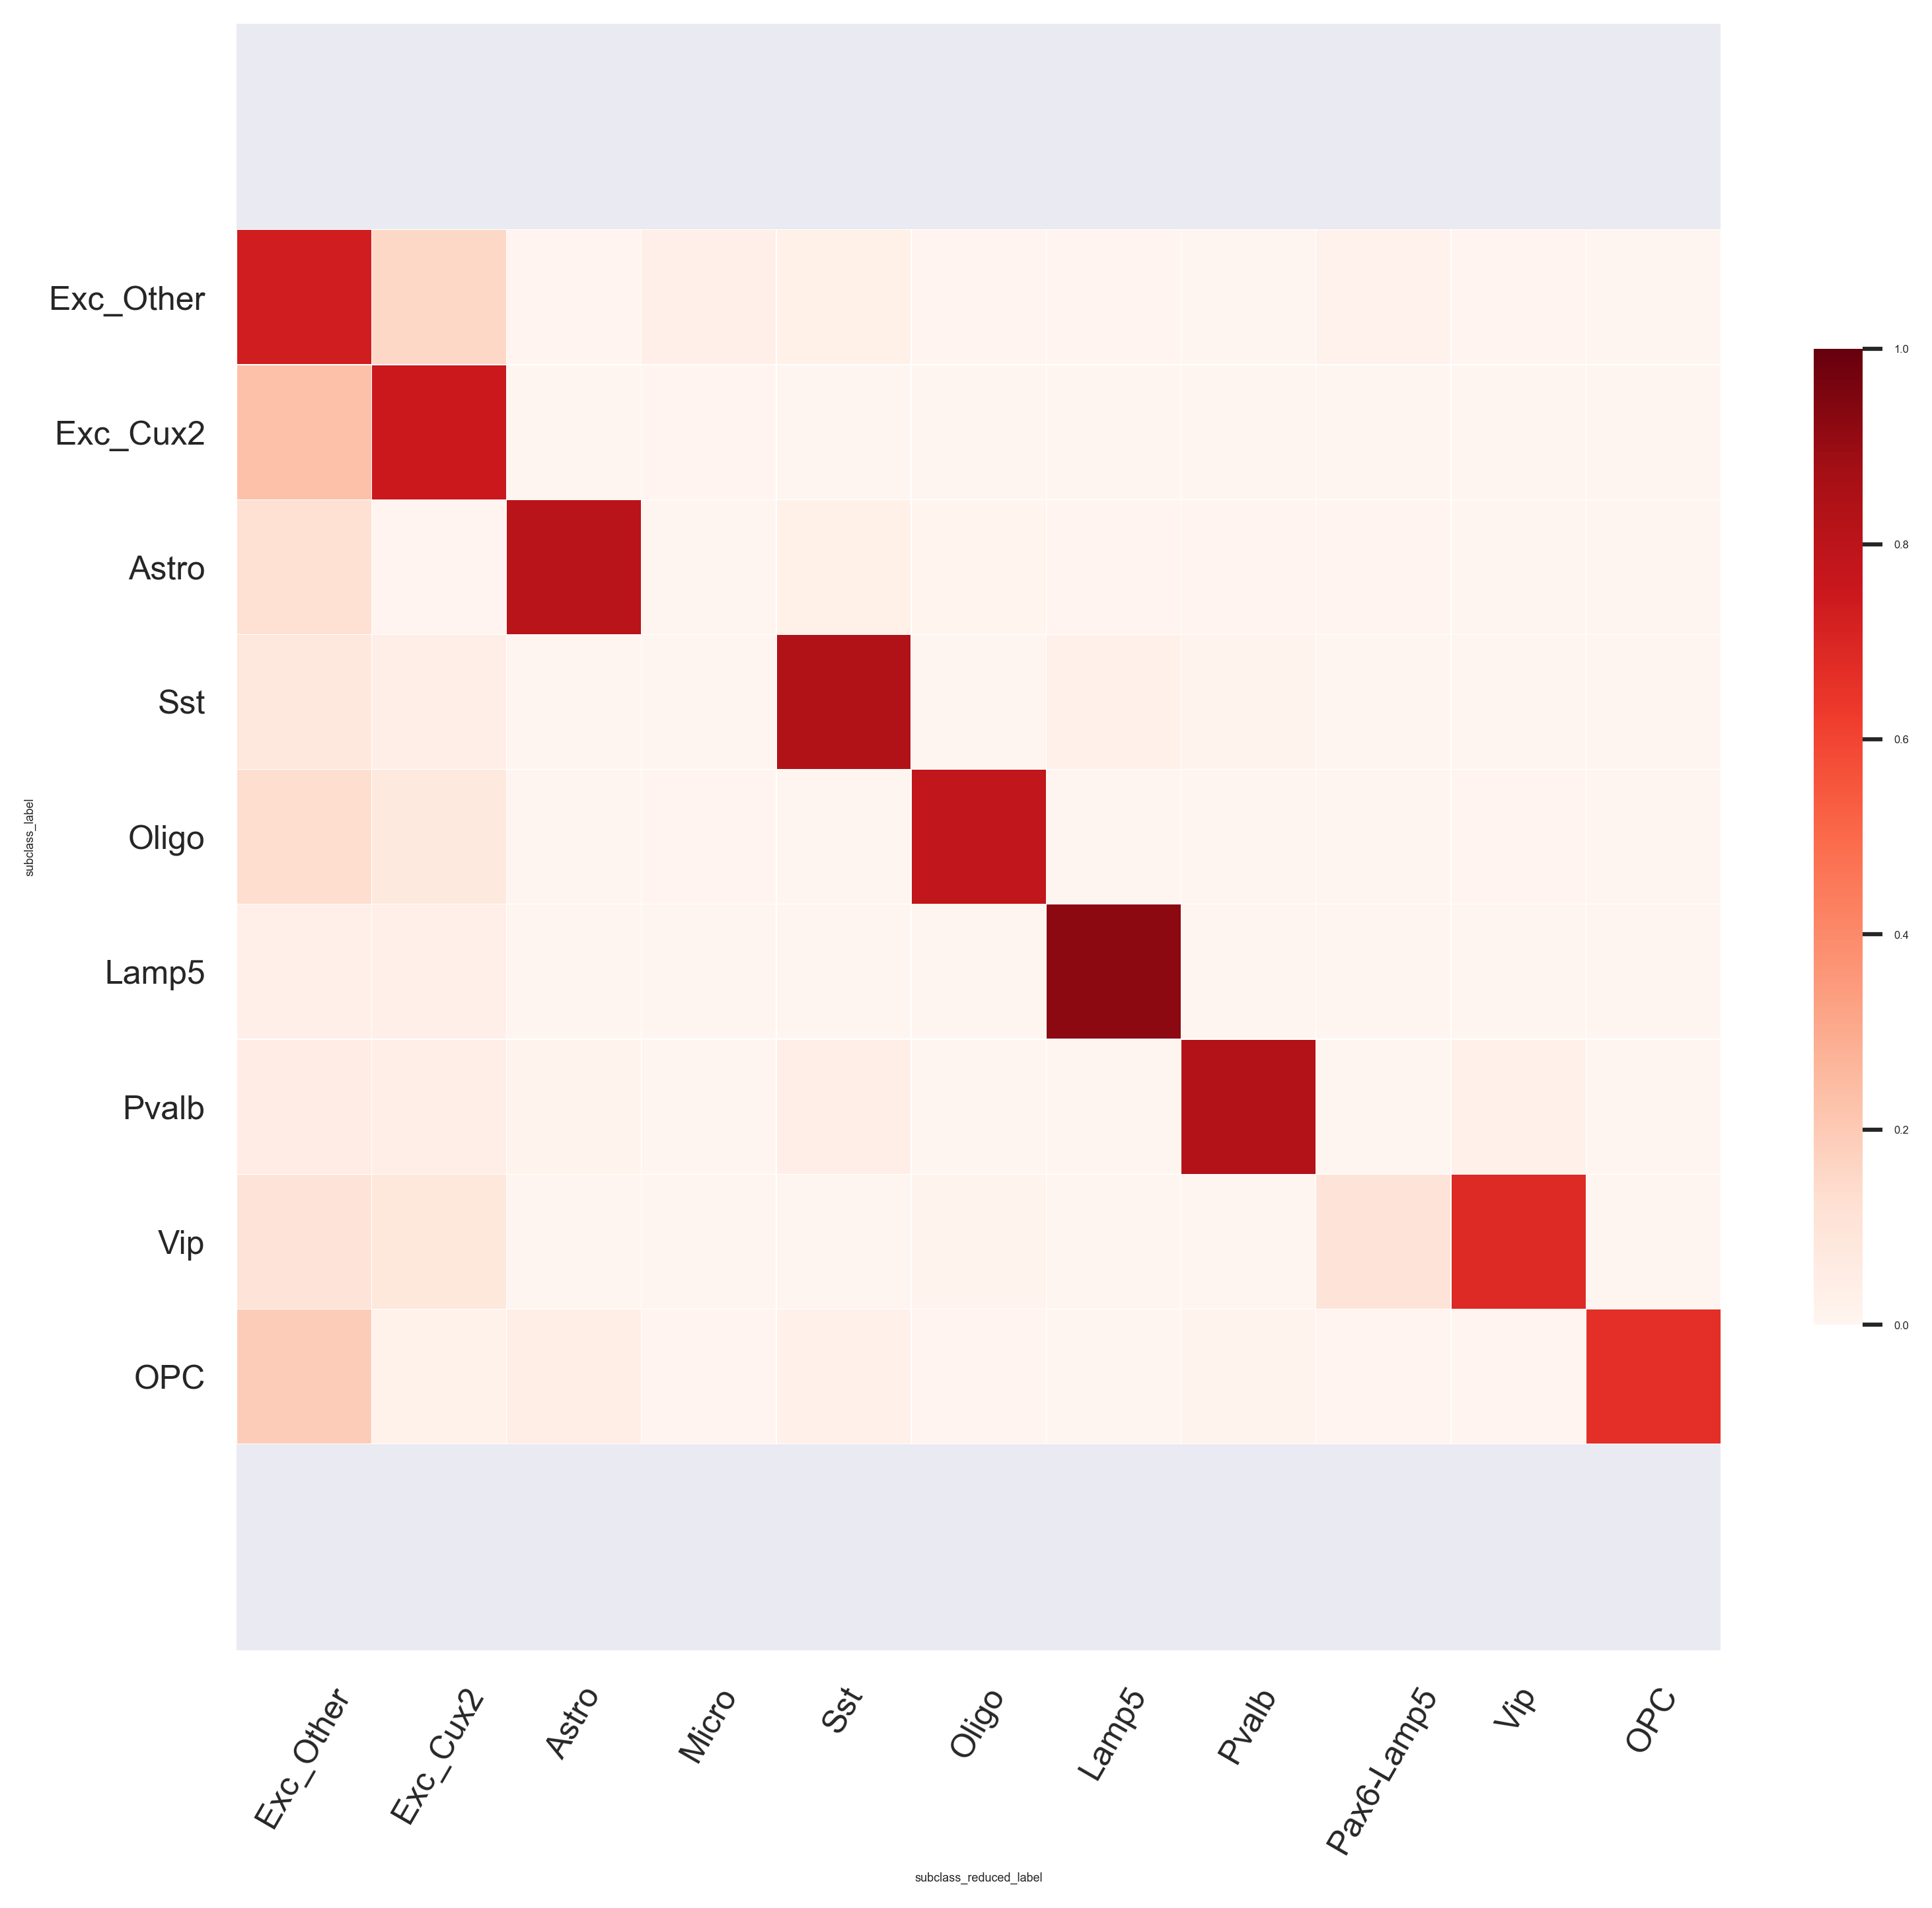

In [142]:
prediction_column = 'subclass_prediction_label'

ref_cluster_column = 'subclass_reduced_label'

query_cluster_column = 'subclass_label'
#query_cluster_column = 'leiden_cluster'



print('Predict cell types.')
predict_classes(nnc, adata_query, prediction_column, genes)
    
# Count predictions
prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
prediction_counts['count'] = 1
    
predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)

predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
#fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
# Plot
fig1=plt.figure(figsize = (10,9))
sns.set(font_scale=0.3)
#sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)   
plt.xticks(rotation = 60)
plt.yticks(rotation = 'horizontal')
plt.xlabel(ref_cluster_column) 
plt.ylabel(query_cluster_column)
plt.axis('equal')
plt.show()

In [122]:
fractions_sorted_by_label

subclass_prediction_label     Lamp5      Sncg       Vip       Sst     Pvalb  \
subclass_label_new                                                            
L2/3 IT                    0.000000  0.000000  0.000000  0.000000  0.000000   
Astro                      0.000000  0.000000  0.000000  0.000000  0.000000   
Lamp5                      0.588764  0.006742  0.031461  0.004494  0.013483   
L5 ET                      0.000000  0.000000  0.000000  0.000000  0.000000   
Endo                       0.000000  0.000000  0.000000  0.000000  0.000000   
L5/6 NP                    0.000000  0.000000  0.000000  0.000000  0.000000   
L6 CT                      0.000000  0.000000  0.000776  0.000776  0.000000   
Sncg                       0.015873  0.571429  0.095238  0.000000  0.015873   
Pvalb                      0.000000  0.000000  0.004484  0.024664  0.668161   
Low Quality                0.000000  0.000000  0.038462  0.000000  0.000000   
L6 IT                      0.002268  0.000000  0.002268  0.000000  0.000000   
Oligo                      0.000000  0.000000  0.000000  0.000000  0.000000   
L5 IT                      0.000000  0.000000  0.000000  0.000000  0.000000   
L4/5 IT                    0.000000  0.000000  0.001471  0.000000  0.000000   
L6b                        0.000000  0.000000  0.000000  0.000000  0.000000   
Micro                      0.000000  0.000000  0.000000  0.000000  0.000000   
Sst                        0.000000  0.000000  0.004348  0.702174  0.065217   
OPC                        0.000000  0.000000  0.000000  0.000000  0.000000   
Vip                        0.009091  0.033333  0.860606  0.000000  0.006061   

subclass_prediction_label   L2/3 IT   L4/5 IT     L5 IT     L6 IT  L6 IT Car3  \
subclass_label_new                                                              
L2/3 IT                    0.858757  0.015537  0.000000  0.001412    0.001412   
Astro                      0.000000  0.000000  0.000000  0.000000    0.000000   
Lamp5                      0.006742  0.000000  0.002247  0.000000    0.002247   
L5 ET                      0.005128  0.005128  0.005128  0.000000    0.000000   
Endo                       0.000000  0.000000  0.000000  0.000000    0.000000   
L5/6 NP                    0.000000  0.056604  0.047170  0.000000    0.000000   
L6 CT                      0.000776  0.000000  0.011646  0.018634    0.000000   
Sncg                       0.000000  0.015873  0.000000  0.000000    0.000000   
Pvalb                      0.006726  0.017937  0.051570  0.000000    0.002242   
Low Quality                0.000000  0.000000  0.346154  0.000000    0.000000   
L6 IT                      0.022676  0.006803  0.145125  0.621315    0.002268   
Oligo                      0.000000  0.000000  0.000000  0.000000    0.000000   
L5 IT                      0.002105  0.138947  0.713684  0.002105    0.000000   
L4/5 IT                    0.114706  0.454412  0.041176  0.000000    0.001471   
L6b                        0.000000  0.017857  0.005952  0.000000    0.000000   
Micro                      0.000000  0.000000  0.000000  0.000000    0.000000   
Sst                        0.021739  0.028261  0.000000  0.000000    0.002174   
OPC                        0.000000  0.000000  0.000000  0.000000    0.000000   
Vip                        0.000000  0.003030  0.000000  0.000000    0.000000   

subclass_prediction_label  ...     Astro       OPC     Oligo      Endo  \
subclass_label_new         ...                                           
L2/3 IT                    ...  0.011299  0.001412  0.000000  0.077684   
Astro                      ...  0.526882  0.000000  0.000000  0.333333   
Lamp5                      ...  0.103371  0.000000  0.017978  0.148315   
L5 ET                      ...  0.005128  0.000000  0.005128  0.035897   
Endo                       ...  0.000000  0.000000  0.000000  0.833333   
L5/6 NP                    ...  0.000000  0.000000  0.009434  0.136792   
L6 CT                      ...  0.000776  0.00

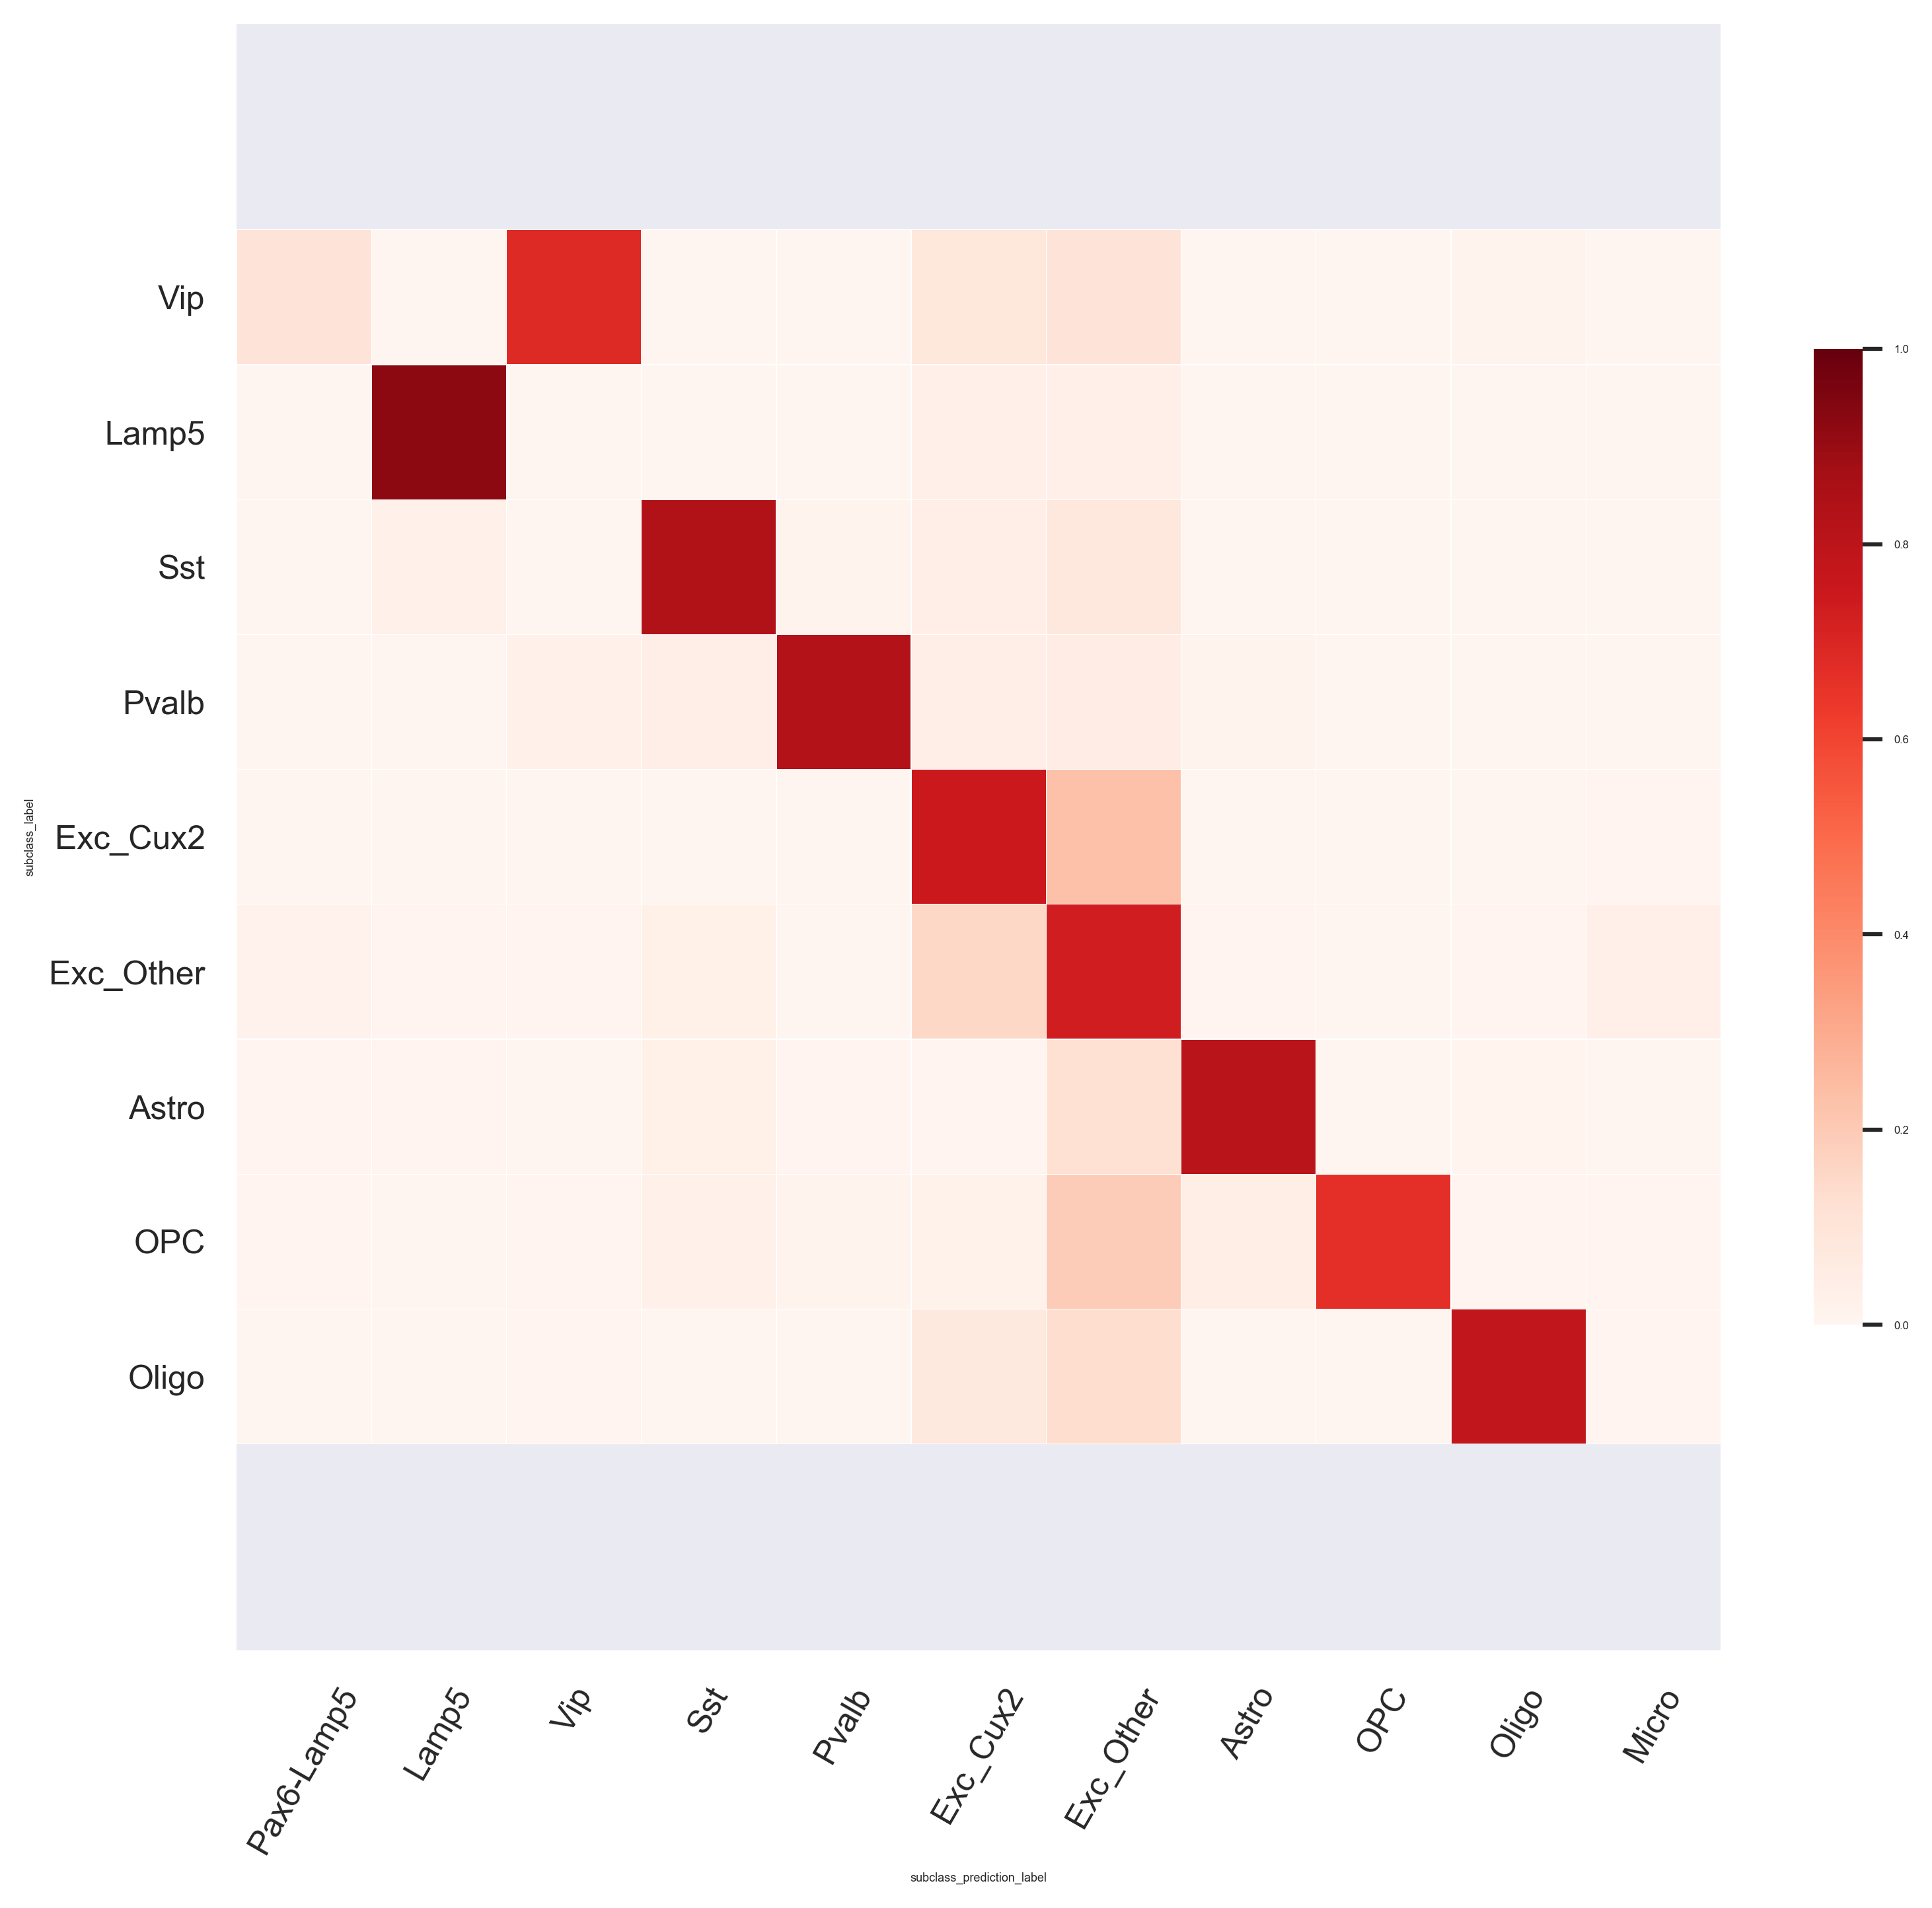

In [143]:
# sort the labels along the x-axis (optional)

sorted_predicted_labels = ['Pax6-Lamp5','Lamp5','Vip','Sst','Pvalb','Exc_Cux2','Exc_Other',
                          'Astro','OPC','Oligo',
                         'Micro']

# sort column
fractions_sorted_by_label = fractions_sorted[sorted_predicted_labels]
# sort index
fractions_sorted_by_label.reindex(['Pax6-Lamp5','Lamp5','Vip','Sst','Pvalb','Exc_Cux2','Exc_Other',
                          'Astro','OPC','Oligo',
                         'Micro']
                         )

sorted_coor_df, rows, columns = runPermutation(fractions_sorted_by_label,'Rows',maxIter = 500,maxTrys = 25)

manual_coor_df = sorted_coor_df


_plot = True
if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    
    plt.xticks(rotation = 60)
    plt.yticks(rotation = 'horizontal')
    
    
    #plt.xlabel(sorted_coor_df.columns) 
    #plt.ylabel(sorted_coor_df.index)
    plt.axis('equal')
    plt.show()

In [132]:
np.unique(adata.obs.subclass_label_new)

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Low Quality', 'Micro', 'OPC',
       'Oligo', 'Pvalb', 'Sncg', 'Sst', 'Vip'], dtype=object)

In [133]:
adata.write(os.path.join(data_path,r'MOp_smart_sn_labeled.h5ad'))

... storing 'subclass_label_new' as categorical
... storing 'subclass_prediction_label' as categorical


## 2.5 Load labeled Anndata to check

In [134]:
adata = sc.read(os.path.join(data_path,r'MOp_smart_sn_labeled.h5ad'))

In [149]:
marker_genes_dict = {
    'L2/3 IT': ['Cux2', 'Slc30a3','Otof'],
    'L4/5 IT': ['Rorb', 'Slc30a3','Rspo1'],
    'L5 IT': ['Slc30a3','Slc17a7'],
    'L6 IT': ['Slc30a3','Slc17a7','Osr1'],
    'L5 ET': ['Sulf2',"Fam84b",'Fezf2'],
    'L6 CT': ['Syt6'],
    'L6b': ['Slc17a7','Cplx3'],
    'L5/6 NP': ['Fezf2','Tshz2'],
    'Pvalb': ['Pvalb','Slc32a1'],
    'Sst': ['Sst','Slc32a1'],
    'Vip': ['Vip','Slc32a1'],
    'Sncg': ['Sncg','Slc32a1'],
    'Lamp5': ['Lamp5','Slc32a1'],
    'Oligo': ['Sox10'],
    'OPC': ['Sox10','Pdgfra'],
    'Astro': ['Gfap','Aqp4'],
    'Micro': ['Ctss'],
    'Endo': ['Flt1'],
    'Low Quality': [],
}

In [167]:
marker_genes_list = ['Slc30a3','Slc17a7','Cux2', 'Otof','Rorb', 'Rspo1','Osr1','Sulf2',"Fam84b",'Fezf2',
                    'Syt6','Cplx3','Tshz2','Slc32a1','Pvalb','Sst','Vip','Sncg','Lamp5','Sox10','Pdgfra','Gfap','Aqp4',
                    'Ctss','Flt1']
    


In [152]:
marker_genes_dict.keys()

dict_keys(['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 'L5 ET', 'L6 CT', 'L6b', 'L5/6 NP', 'Pvalb', 'Sst', 'Vip', 'Sncg', 'Lamp5', 'Oligo', 'OPC', 'Astro', 'Micro', 'Endo', 'Low Quality'])

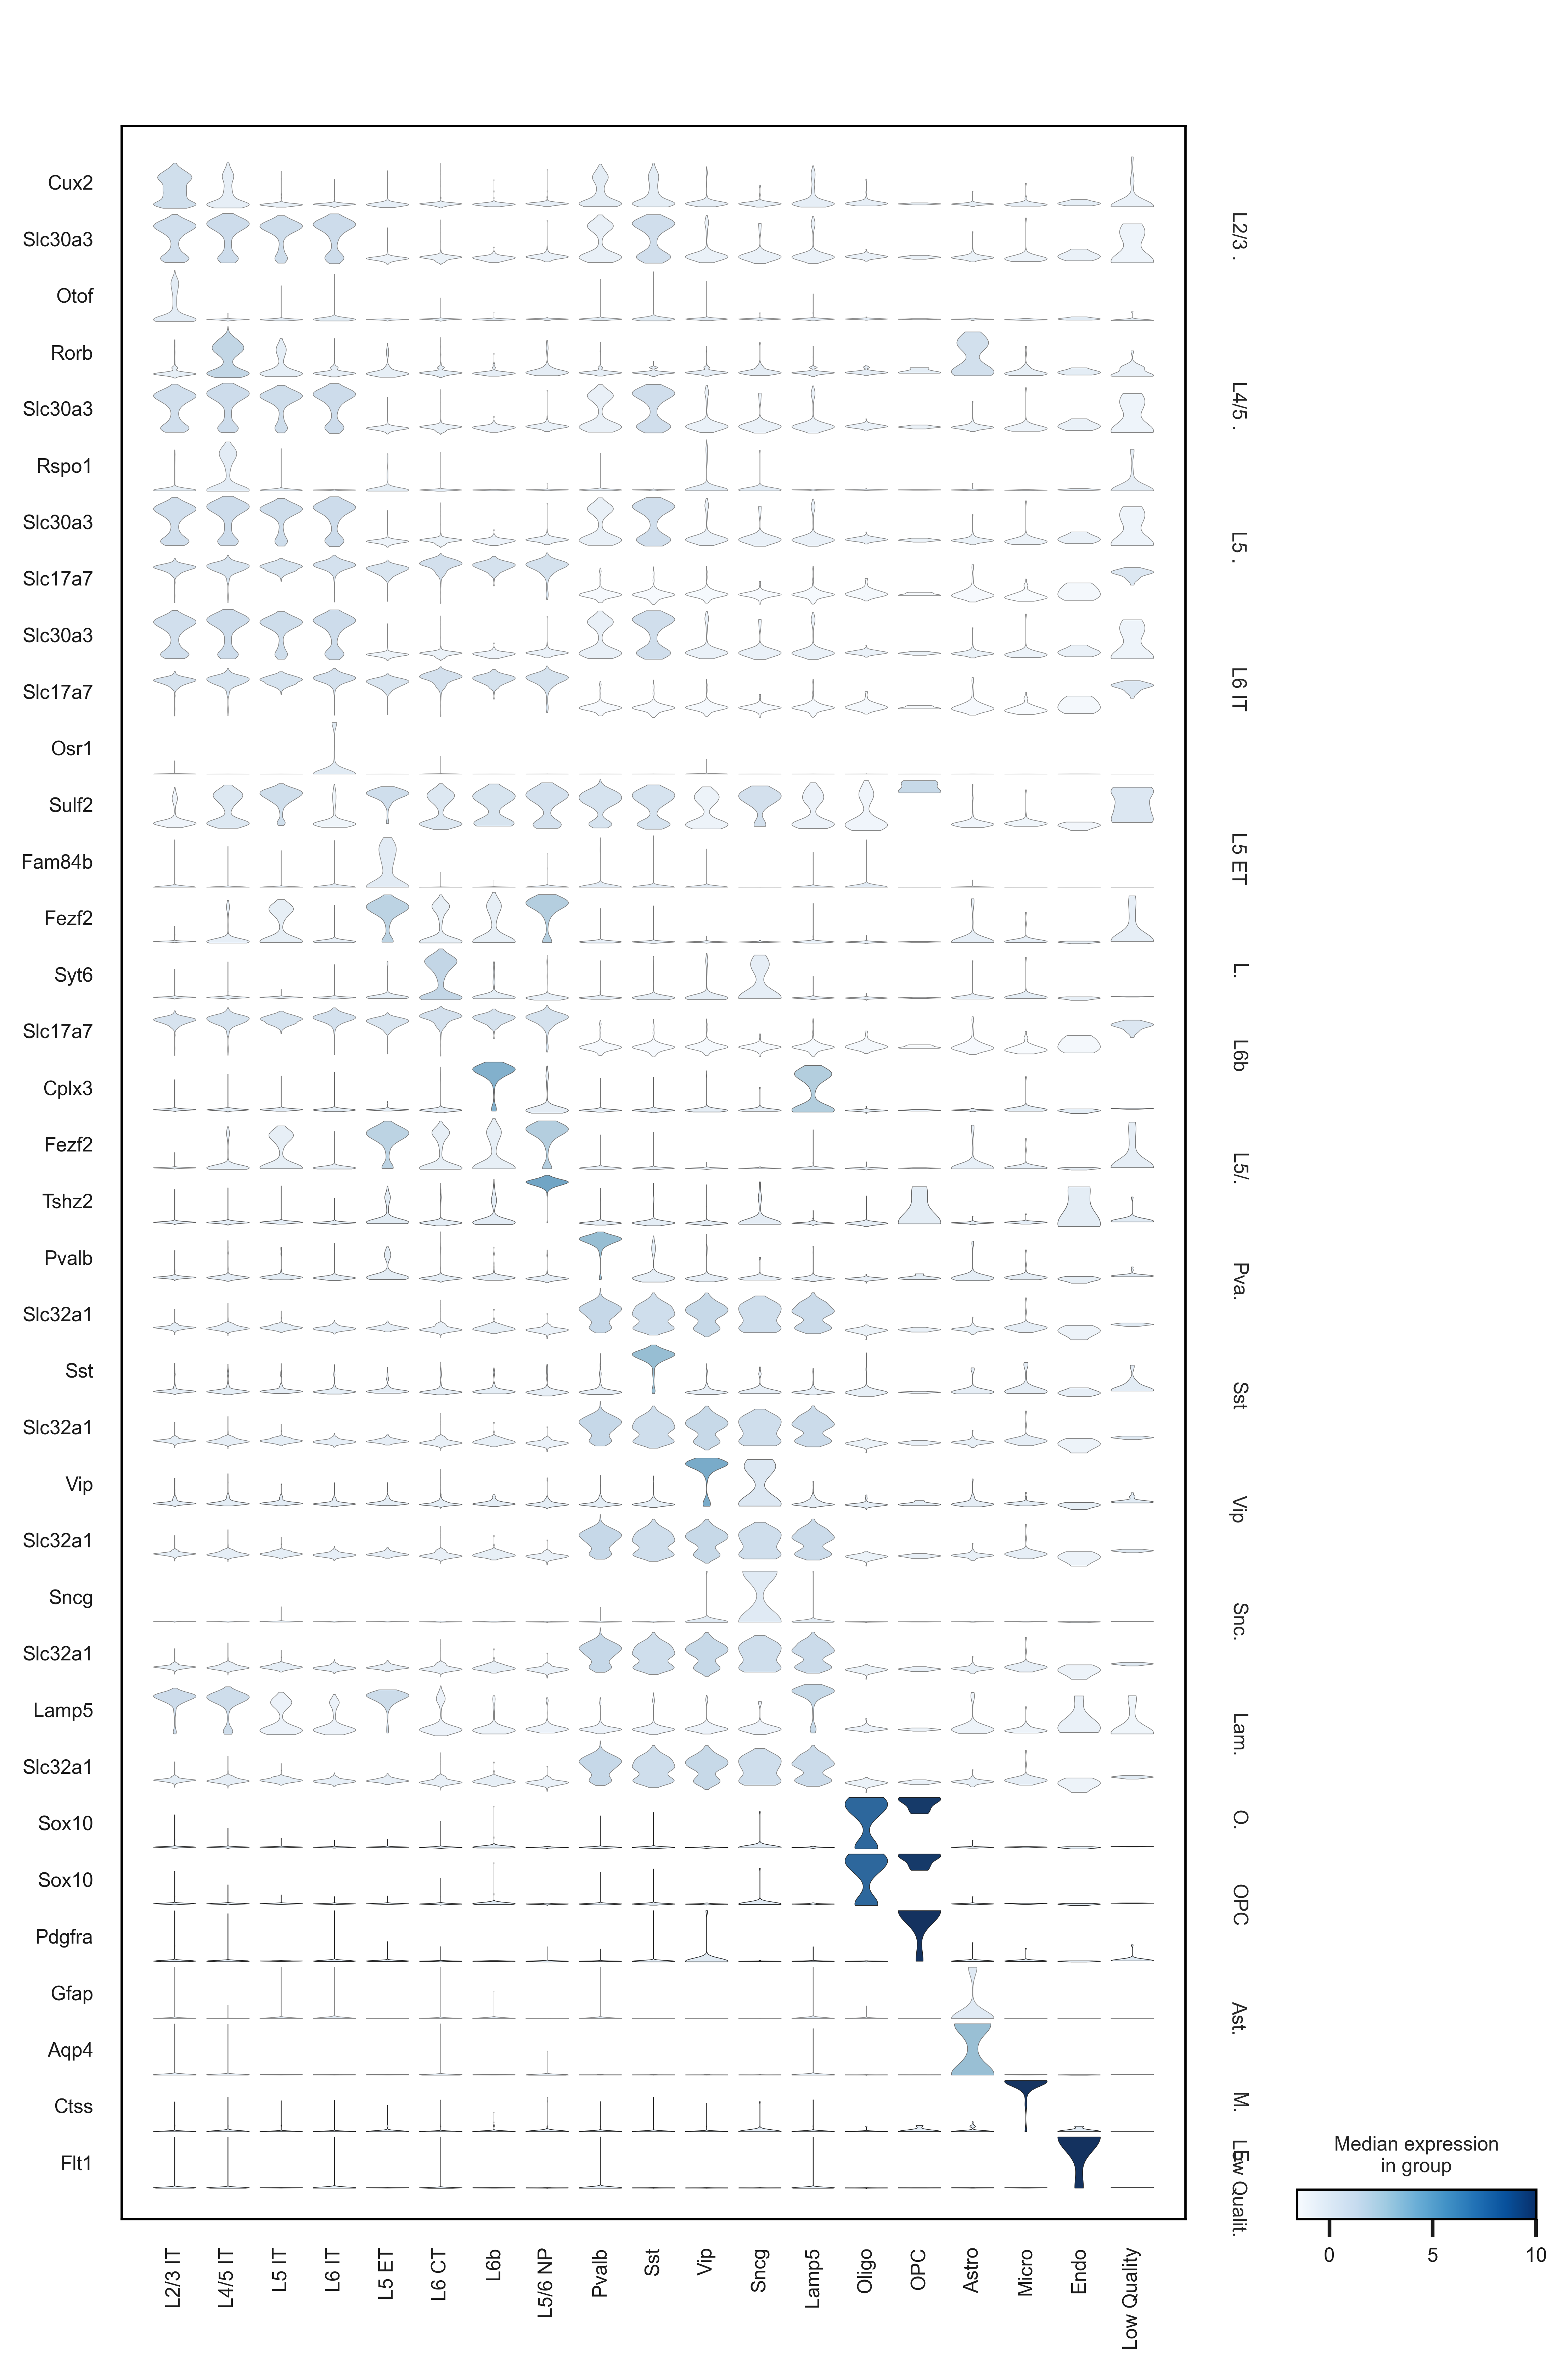

In [161]:
sc.settings.set_figure_params(dpi=300, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

ax = sc.pl.stacked_violin(adata, marker_genes_dict, groupby='subclass_label_new', swap_axes=True, dendrogram=False,
                        fontsize=7,
                         categories_order = marker_genes_dict.keys()
                         )



In [177]:
np.unique(adata.obs['subclass_label_new'])



array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Low Quality', 'Micro', 'OPC',
       'Oligo', 'Pvalb', 'Sncg', 'Sst', 'Vip'], dtype=object)

In [182]:
list(marker_genes_dict.keys())

['L2/3 IT',
 'L4/5 IT',
 'L5 IT',
 'L6 IT',
 'L5 ET',
 'L6 CT',
 'L6b',
 'L5/6 NP',
 'Pvalb',
 'Sst',
 'Vip',
 'Sncg',
 'Lamp5',
 'Oligo',
 'OPC',
 'Astro',
 'Micro',
 'Endo',
 'Low Quality']

In [183]:
sorted_label_order=list(marker_genes_dict.keys())

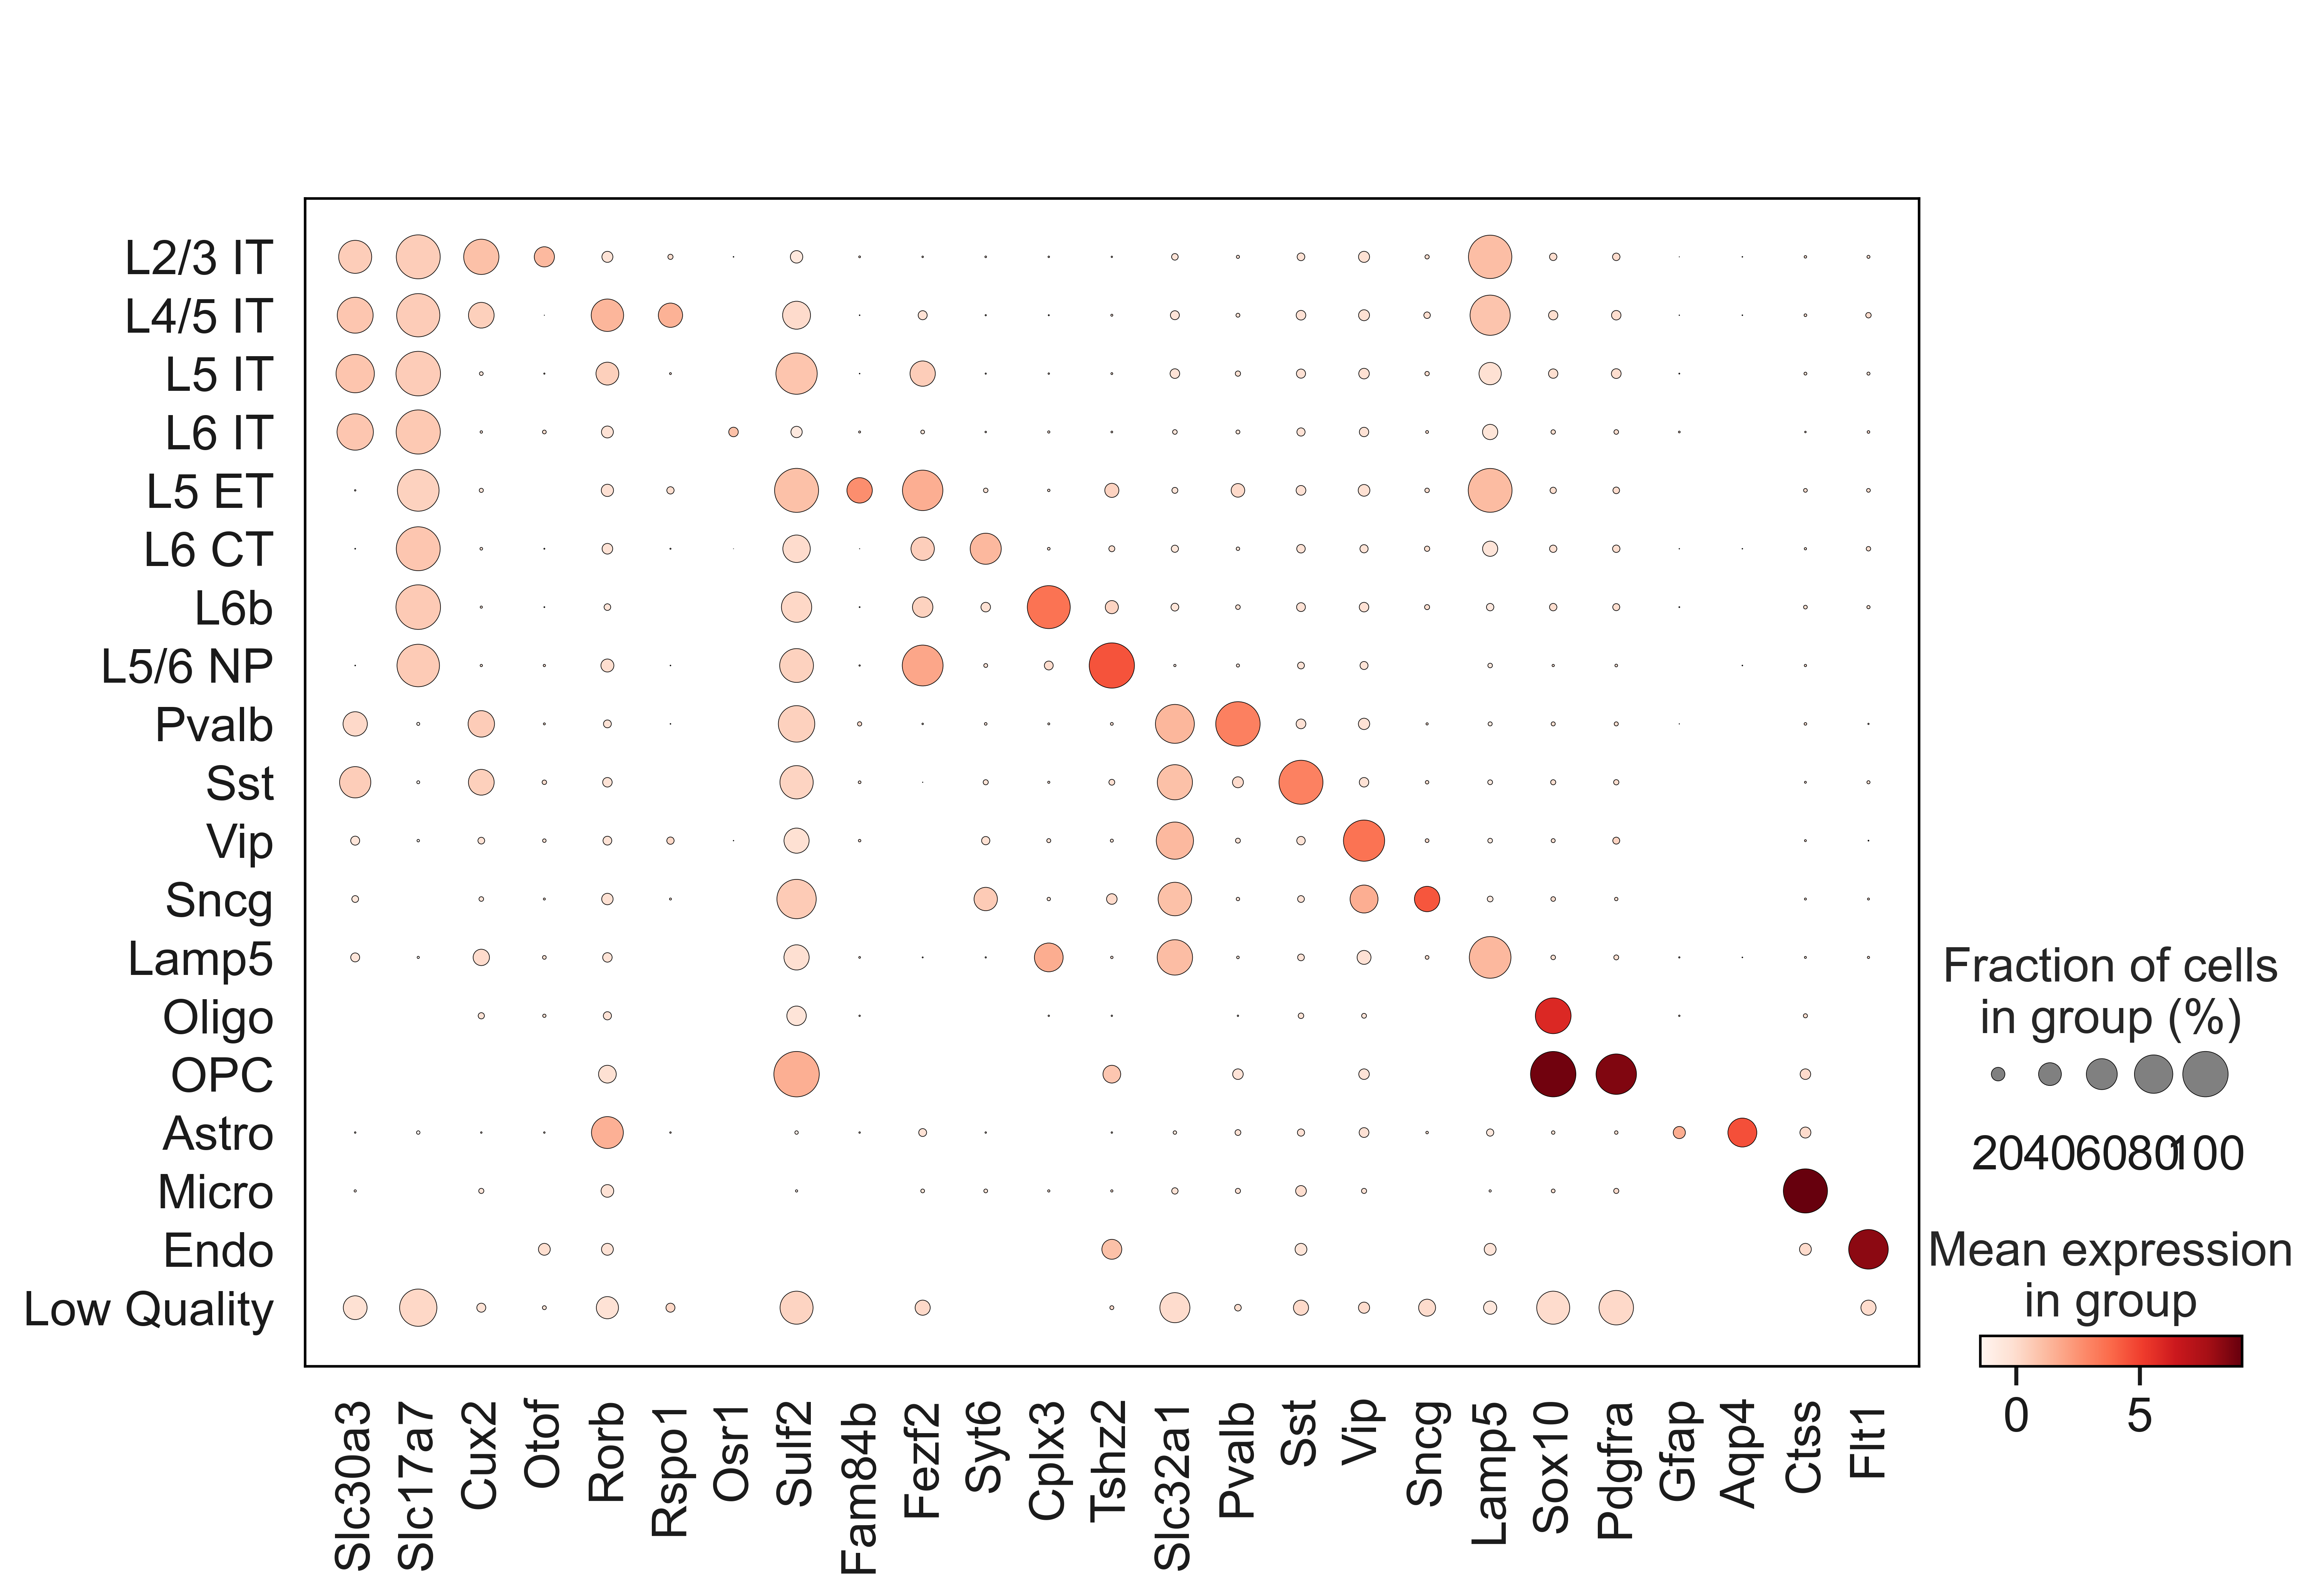

In [186]:
sc.settings.set_figure_params(dpi=300, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=18, )

sc.pl.dotplot(adata, marker_genes_list, groupby='subclass_label_new', dendrogram=False,
             categories_order=sorted_label_order
             )




In [187]:
adata.var_names

Index(['0610005C13Rik', '0610007P14Rik', '0610009B22Rik', '0610009E02Rik',
       '0610009L18Rik', '0610009O20Rik', '0610010B08Rik', '0610010F05Rik',
       '0610010K14Rik', '0610011F06Rik',
       ...
       'Zxda', 'Zxdb', 'Zxdc', 'Zyg11a', 'Zyg11b', 'Zyx', 'Zzef1', 'Zzz3', 'a',
       'l7Rn6'],
      dtype='object', length=33262)

In [189]:
Mop_genes = list(adata.var_names)
Mop_genes

['0610005C13Rik',
 '0610007P14Rik',
 '0610009B22Rik',
 '0610009E02Rik',
 '0610009L18Rik',
 '0610009O20Rik',
 '0610010B08Rik',
 '0610010F05Rik',
 '0610010K14Rik',
 '0610011F06Rik',
 '0610012G03Rik',
 '0610025J13Rik',
 '0610030E20Rik',
 '0610037L13Rik',
 '0610038B21Rik',
 '0610039H22Rik',
 '0610039K10Rik',
 '0610040B10Rik',
 '0610040F04Rik',
 '0610040J01Rik',
 '0610043K17Rik',
 '1010001N08Rik',
 '1110001J03Rik',
 '1110002J07Rik',
 '1110002L01Rik',
 '1110002O04Rik',
 '1110004E09Rik',
 '1110004F10Rik',
 '1110006O24Rik',
 '1110007C09Rik',
 '1110008F13Rik',
 '1110008L16Rik',
 '1110008P14Rik',
 '1110012L19Rik',
 '1110017D15Rik',
 '1110018N20Rik',
 '1110019D14Rik',
 '1110020A21Rik',
 '1110028F11Rik',
 '1110032A03Rik',
 '1110032F04Rik',
 '1110034G24Rik',
 '1110037F02Rik',
 '1110038B12Rik',
 '1110038F14Rik',
 '1110046J04Rik',
 '1110051M20Rik',
 '1110054M08Rik',
 '1110057K04Rik',
 '1110058D11Rik',
 '1110058L19Rik',
 '1110059E24Rik',
 '1110059G10Rik',
 '1110065P20Rik',
 '1190002F15Rik',
 '1190002N

In [190]:
%store Mop_genes
# share the varibale to another notebook

Stored 'Mop_genes' (list)
